In [1]:
import warnings
import sys

warnings.filterwarnings("ignore")
sys.path.append('../../')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from PertCF import *
import pandas as pd
import numpy as np
import pickle
import random

In [14]:
# Set random seed
random_state = random.randint(0, 100)

# Concept name
concept = 'credit'

column_names = ['status', 'duration', 'credit_history', 'purpose', 'amount', 'savings',
       'employment_duration', 'installment_rate',
       'other_debtors', 'present_residence', 'property', 'age',
       'other_installment_plans', 'housing', 'number_credits', 'job',
       'people_liable', 'telephone', 'foreign_worker', 'credit_risk']
train_cols= column_names[:-1]

label = 'credit_risk'

class_names = ['0','1']


num_cols = ['duration','amount','age']
cat_cols = ['status', 'credit_history', 'purpose', 'savings','employment_duration', 
            'installment_rate', 'other_debtors', 'present_residence', 
            'property', 'other_installment_plans', 'housing', 'number_credits', 'job',
            'people_liable', 'telephone', 'foreign_worker']


df =  pd.read_csv('./data/german_creditt.csv',sep=';')
df = df.drop(['personal_status_sex'], axis=1)

dic = { 'bad':'0' , 'good':'1'}
df[label] = df[label].map(dic)


In [15]:
def label_dict(df, name):
    dic_status = {}
    lst = list(df[name].unique())
    for i in range(len(lst)):
        dic_status[lst[i]] = i 
    return dic_status

def rev(dic):
    return {v: k for k, v in dic.items()}

# from categoric features to numeric features with maps
# from numeric features to categoric features with inv_maps
def encode(df, maps):
    for i in cat_cols:
        df[i] = df[i].map(maps[i]).astype('float')
    return df
    

In [16]:
maps = {'status':label_dict(df,'status'), 'credit_history':label_dict(df,'credit_history'), 
        'purpose':label_dict(df,'purpose'), 'savings':label_dict(df,'savings'),
        'employment_duration':label_dict(df,'employment_duration'), 
        'installment_rate':label_dict(df,'installment_rate'), 'other_debtors':label_dict(df,'other_debtors'), 
        'present_residence':label_dict(df,'present_residence'), 'property':label_dict(df,'property'), 
        'other_installment_plans':label_dict(df,'other_installment_plans'), 'housing':label_dict(df,'housing'), 
        'number_credits':label_dict(df,'number_credits'), 'job':label_dict(df,'job'),
        'people_liable':label_dict(df,'people_liable'), 'telephone':label_dict(df,'telephone'), 
        'foreign_worker':label_dict(df,'foreign_worker'),'credit_risk':label_dict(df,'credit_risk')}

In [18]:
X = df[train_cols]
y = df[label]

# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)  

train = X_train.join(y_train)
test = X_test.join(y_test)

In [19]:
# Save datasets
train.to_pickle("./Data/train.pkl")
test.to_pickle("./Data/test.pkl")

---

In [20]:
# encoding for training the model
X_en = encode(X.copy(), maps)
X_train_en, X_test_en = encode(X_train.copy(), maps), encode(X_test.copy(), maps)
train_en = encode(train.copy(), maps)
test_en = encode(test.copy(), maps)


In [21]:
# Model
model = RandomForestClassifier()
model = model.fit(X_train_en, y_train)
print('Score:', model.score(X_test_en, y_test))

# save model
model_path = './Model/model_rf.pkl'
pickle.dump(model, open(model_path, "wb"))

# load model
#loaded_model = pickle.load(open(model_path, "rb"))

Score: 0.81


In [22]:
# Model
model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5, max_depth=5, random_state=random_state)
model = model.fit(X_train_en, y_train)
print('Score:', model.score(X_test_en, y_test))

# save model
model_path = './Model/model_GBC.pkl'
pickle.dump(model, open(model_path, "wb"))

# load model
#loaded_model = pickle.load(open(model_path, "rb"))

Score: 0.8


---

In [23]:
def shapValues(X_train, model, class_names, label):
        
        if len(X_train)>300:
            df = X_train.sample(300)
        else:
            df = X_train.copy()
        
        for column in df.columns:
            if df[column].dtype not in ['int64']:
                df[column] = df[column].astype('category').cat.codes

        # Create shap kernel explainer using model and training data
        explainer = shap.KernelExplainer(model.predict_proba, df)

        # Shap values calculated by explainer
        shap_values = explainer.shap_values(df)


        # Create df from mean of shap values (map the order of features and classes)
        mean_classes = []
        for i in range(len(shap_values)):
            mean_classes.append(np.mean(np.abs(shap_values[i]), axis=0))

        shap_df = pd.DataFrame(mean_classes, index=class_names, 
                                    columns=X_train.columns.tolist())

        num_class = len(shap_df)

        # Wheight of label = 0 
        shap_df[label] = np.zeros(num_class)
        
        # normalize shap values
        shap_df =  shap_df.div(shap_df.sum(axis=1), axis=0)   
        
        return shap_df

In [24]:
shap_df = shapValues(X_train, model, class_names, label)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

In [25]:
shap_df

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0.087489,0.065615,0.072804,0.094283,0.096175,0.029996,0.096546,0.062598,0.021956,0.027843,0.054467,0.081371,0.013236,0.052931,0.082674,0.020478,0.016878,0.013406,0.009256,0.0
1,0.087489,0.065615,0.072804,0.094283,0.096175,0.029996,0.096546,0.062598,0.021956,0.027843,0.054467,0.081371,0.013236,0.052931,0.082674,0.020478,0.016878,0.013406,0.009256,0.0


In [26]:
shap_df.to_pickle("./temp_files/shap_df.pkl")

<AxesSubplot: >

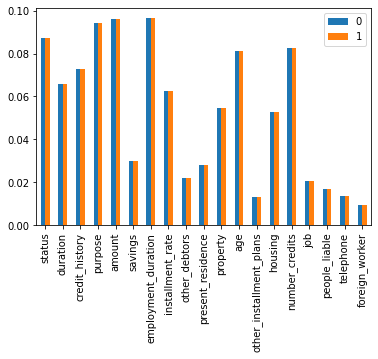

In [27]:
shap_df[train_cols].T.plot.bar()